# Creation of dataframe for gravity model

- join on cityname
- create city dataframe (nodes)
- create separate city-pairs dataframes (basically edges)
- calculate distances

In [189]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import re
from tqdm.notebook import tqdm
import unidecode
from collections import Counter
import shapely

In [2]:
INDIR = "../../input"
OUTDIR = "../../output"
DATADIR = "../../../../data"
FILE_cities = "List_of_cities_300k.csv"
FILE_coords = "euro-global-map-shp/data/FullEurope/BuiltupP.shp" #path/to/shapefile

In [3]:
# load citylist
list_of_cities = pd.read_csv(os.path.join(INDIR, FILE_cities), sep=";")
list_of_cities.head()

,id_MUA,Mua,Mua_en,Mua_fr,SizeMUA1k,EU15,Code_Country,NUTS_1,NUTS_2,NUTS_3,...,PUR,Supra_poly_fua,PIA,Name_supra_poly_fua,Poly_fua,id_poly_fua,Name_poly_fua,SizeHinterland1k,GDP_per_capita,Dummy_Capital
0,FR00810,Paris,Paris,Paris,9591,1,FR,FR1,FR10,FR101,...,,0,PIA_Paris,99,0,,,1201,44,1
1,UK01886,London,London,Londres,8256,1,UK,UKI,UKI1,UKI11,...,,0,PIA_London,99,0,,,2752,45,1
2,ES00540,Madrid,Madrid,Madrid,4955,1,ES,ES3,ES30,ES300,...,,0,PIA_Madrid,99,0,,,308,29,1
3,DE00219,Berlin,Berlin,Berlin,3776,1,DE,DE3,DE30,DE300,...,,0,PIA_Berlin,99,0,,,240,22,1
4,IT01156,Milano,Milan,Milan,3698,1,IT,ITC,ITC4,ITC45,...,Milano,0,PIA_Milano,99,1,IT03,Milano metropolitan area,604,35,0


## Select relevant coordinates

In [4]:
built_up_complete = gpd.read_file(os.path.join(DATADIR, FILE_coords))

In [5]:
built_up_complete.head(5)

,OBJECTID,FCsubtype,inspireId,beginLifes,F_CODE,ICC,NAMN1,NAMN2,NAMA1,NAMA2,NLN1,NLN2,PPL,PP1,PP2,USE,PopulatedP,geometry
0,1,1,_EG.EGM.BuiltupP:40c2730a-3a4b-474b-8f55-615cd...,20220125104612,AL020,MD,Cernoleuca,UNK,Cernoleuca,UNK,rum,UNK,1771,-32768,-32768,3,N.MD.BUILTUP.000823,POINT (27.56031 48.31269)
1,2,1,_EG.EGM.BuiltupP:f90e3db3-2ef5-4cf7-95ba-2f99f...,20220125104612,AL020,MD,Mo?ana,UNK,Mosana,UNK,rum,UNK,1630,-32768,-32768,3,N.MD.BUILTUP.000825,POINT (27.68990 48.32328)
2,3,1,_EG.EGM.BuiltupP:d947c478-818e-41ed-91a2-0aa79...,20220125104612,AL020,MD,Gribova,UNK,Gribova,UNK,rum,UNK,2101,-32768,-32768,3,N.MD.BUILTUP.000831,POINT (27.93089 48.01388)
3,4,1,_EG.EGM.BuiltupP:0f9b7f83-5249-4030-9933-417ed...,20220125104612,AL020,MD,Chirca,UNK,Chirca,UNK,rum,UNK,1704,-32768,-32768,3,N.MD.BUILTUP.000838,POINT (29.10819 46.92171)
4,5,1,_EG.EGM.BuiltupP:0e4be3d7-1937-4614-a7fd-f6bd2...,20220125104612,AL020,MD,Delac?u,UNK,Delacau,UNK,rum,UNK,2126,-32768,-32768,3,N.MD.BUILTUP.000840,POINT (29.30339 47.09902)


In [6]:
built_up_complete.shape

(72846, 18)

In [7]:
built_up = built_up_complete

In [8]:
built_up.shape

(72846, 18)

In [9]:
muas = list(list_of_cities.Mua)

In [10]:
mua_dict = dict()

for index, row in list_of_cities.iterrows():
    if row['Code_Country'] == 'UK': 
        mua_dict[row['Mua']] = 'GB'
    else: 
        mua_dict[row['Mua']] = row['Code_Country']
    

### Names with issues:

At least some of these non matches are combined cities. For these it is probably easiest to choose the coordinates of one. (although i guess the best option would be to calculate the midpoint between the combined cities and then take that);

Another problem is that unidecode replaces 'ü' with 'u' while the `NAMA1` variable lists this with 'ue'. Same for 'oe'.

Den Haag --> 's-Gravenhage (den Haag listed as NAMA2)

**Manual edits**

Antwerp listed with its dutch/flemish name Antwerpen. Brussels as Brussel

Don't understand what is happening to Lyon and Marseille. (listed only with arrondissement numbers in name, e.g. 'Lyon 1er Arrondissement')

error for Gent (negative population number)  
Sofia should be done manually as well (other Sofias are present but Sofia, BU is listed as 'S?fiya')

Stoke --> Stoke-on-Trent
Belfast cause country code does not match

Plovdiv --> Pl?vdiv

Wuppertal not in the dataset. 

suggested process:
1. un-decoded (so with accents). match to NAMA1 first. 
2. Then new list with left over cities, match to NAMN1 (for the umlauts).
3. left-over match to NAMN2
4. Manually match remaining cities




In [11]:
cities = []
for index, row in built_up.iterrows(): 
    if row['NAMA1'] in mua_dict and row['ICC'] == mua_dict[row['NAMA1']]:
        cities.append(row['NAMA1'])
    elif row['NAMN1'] in mua_dict and row['ICC'] == mua_dict[row['NAMN1']]:
        cities.append(row['NAMN1'])
    elif row['NAMN2'] in mua_dict and row['ICC'] == mua_dict[row['NAMN2']]: 
        cities.append(row['NAMN2'])

In [12]:
len(cities)

137

In [13]:
city_counts = Counter(cities) 
for key in city_counts:
    if city_counts[key] > 1:
        print(key)

Bremen
Leeds


In [14]:
# cities not automatically matched
leftovers = []
for city in muas:
    if city not in cities:
        leftovers.append(city)

In [15]:
# length of complete list - length of initial 'matches'
print(len(muas) - len(cities))

# length unmatched cities
print(len(leftovers))

14
16


In [16]:
leftovers

['Brussels',
 'Kobenhavn',
 'Lyon',
 'Sofia',
 'Essen-Oberhausen',
 'Marseille',
 'Antwerp',
 'Bochum-Herne',
 'Gelsenkirchen-Bottrop',
 'Belfast',
 'Palma de Mallorca',
 'Wuppertal',
 'Castellammare di Stabia-Torre Annunziata',
 'Plovdiv',
 'Alicanta',
 'La Coruna']

In [17]:
manual_names_v = {"Pl?vdiv":"Plovdiv", 
                "S?fiya":"Sofia", 
                "Koebenhavn": "Kobenhavn", 
                "Brussel": "Brussels", 
                "Antwerpen": "Antwerp",
                "A Coruna": "La Coruna", 
                "Alacant/Alicante": "Alicanta", 
                "Lyon 1er Arrondissement": "Lyon", 
                "Marseille 1er Arrondissement": "Marseille", 
                "Mallorca": "Palma de Mallorca"}

In [18]:
# add one of the compound cities to the dictionary
for city in leftovers:
    if '-' in city:
        manual_names_v[city.split('-')[0]] = city

In [19]:
manual_names_v

{'Pl?vdiv': 'Plovdiv',
 'S?fiya': 'Sofia',
 'Koebenhavn': 'Kobenhavn',
 'Brussel': 'Brussels',
 'Antwerpen': 'Antwerp',
 'A Coruna': 'La Coruna',
 'Alacant/Alicante': 'Alicanta',
 'Lyon 1er Arrondissement': 'Lyon',
 'Marseille 1er Arrondissement': 'Marseille',
 'Mallorca': 'Palma de Mallorca',
 'Essen': 'Essen-Oberhausen',
 'Bochum': 'Bochum-Herne',
 'Gelsenkirchen': 'Gelsenkirchen-Bottrop',
 'Castellammare di Stabia': 'Castellammare di Stabia-Torre Annunziata'}

In [20]:
manual_names_r = {value: key for key, value in manual_names_v.items()}

In [21]:
manual_names_r

{'Plovdiv': 'Pl?vdiv',
 'Sofia': 'S?fiya',
 'Kobenhavn': 'Koebenhavn',
 'Brussels': 'Brussel',
 'Antwerp': 'Antwerpen',
 'La Coruna': 'A Coruna',
 'Alicanta': 'Alacant/Alicante',
 'Lyon': 'Lyon 1er Arrondissement',
 'Marseille': 'Marseille 1er Arrondissement',
 'Palma de Mallorca': 'Mallorca',
 'Essen-Oberhausen': 'Essen',
 'Bochum-Herne': 'Bochum',
 'Gelsenkirchen-Bottrop': 'Gelsenkirchen',
 'Castellammare di Stabia-Torre Annunziata': 'Castellammare di Stabia'}

In [22]:
for key in manual_names_v:
    mua_dict[key] = mua_dict[manual_names_v[key]]

In [23]:
mua_dict

{'Paris': 'FR',
 'London': 'GB',
 'Madrid': 'ES',
 'Berlin': 'DE',
 'Milano': 'IT',
 'Barcelona': 'ES',
 'Athinai': 'GR',
 'Roma': 'IT',
 'Birmingham': 'GB',
 'Lisboa': 'PT',
 'Napoli': 'IT',
 'Katowice': 'PL',
 'Manchester': 'GB',
 'Hamburg': 'DE',
 'Budapest': 'HU',
 'Bucuresti': 'RO',
 'Warszawa': 'PL',
 'Stuttgart': 'DE',
 'Wien': 'AT',
 'München': 'DE',
 'Brussels': 'BE',
 'Stockholm': 'SE',
 'Frankfurt am Main': 'DE',
 'Köln': 'DE',
 'Kobenhavn': 'DK',
 'Valencia': 'ES',
 'Torino': 'IT',
 'Glasgow': 'GB',
 'Praha': 'CZ',
 'Lyon': 'FR',
 'Sofia': 'BG',
 'Liverpool': 'GB',
 'Porto': 'PT',
 'Sevilla': 'ES',
 'Dublin': 'IE',
 'Helsinki': 'FI',
 'Amsterdam': 'NL',
 'Rotterdam': 'NL',
 'Düsseldorf': 'DE',
 'Essen-Oberhausen': 'DE',
 'Lille': 'FR',
 'Lodz': 'PL',
 'Marseille': 'FR',
 'Antwerp': 'BE',
 'Bilbao': 'ES',
 'Newcastle upon Tyne': 'GB',
 'Krakow': 'PL',
 'Bochum-Herne': 'DE',
 'Thessaloniki': 'GR',
 'Nürnberg': 'DE',
 'Riga': 'LV',
 'Duisburg': 'DE',
 'Dortmund': 'DE',
 'Hanno

In [24]:
cities = []
for index, row in built_up.iterrows(): 
    if row['NAMA1'] in mua_dict and row['ICC'] == mua_dict[row['NAMA1']]:
        cities.append(row['NAMA1'])
    elif row['NAMN1'] in mua_dict and row['ICC'] == mua_dict[row['NAMN1']]:
        cities.append(row['NAMN1'])
    elif row['NAMN2'] in mua_dict and row['ICC'] == mua_dict[row['NAMN2']]: 
        cities.append(row['NAMN2'])

In [25]:
len(cities)

151

In [26]:
muas_2 = []
for city in muas: 
    if city in manual_names_r: 
        muas_2.append(manual_names_r[city])
    else: 
        muas_2.append(city)

In [27]:
# Cities not matched
leftovers = []
for city in muas_2:
    if city not in cities:
        leftovers.append(city)
leftovers

['Belfast', 'Wuppertal']

In [28]:
# cities matched more than once
city_counts = Counter(cities) 
for key in city_counts:
    if city_counts[key] > 1:
        print(key)

Bremen
Leeds


***

### Create new dataframe

In [29]:
df = []
for index, row in built_up.iterrows(): 
    if row['NAMA1'] in mua_dict and row['ICC'] == mua_dict[row['NAMA1']]:
        df.append(tuple(row))
    elif row['NAMN1'] in mua_dict and row['ICC'] == mua_dict[row['NAMN1']]:
        df.append(tuple(row))
    elif row['NAMN2'] in mua_dict and row['ICC'] == mua_dict[row['NAMN2']]: 
        df.append(tuple(row))
    elif row['NAMA1'] == "Belfast":
        df.append(tuple(row))

In [30]:
df2 = pd.DataFrame(df, columns = built_up.columns)

In [31]:
# exclude the duplicate Bremen and Leeds
# Wrong BREMEN 27573
# Wrong LEEDS 63132

In [32]:
duplicate_IDs = [27573, 63132]
gdf = built_up[(~built_up.OBJECTID.isin(duplicate_IDs)) & (built_up.OBJECTID.isin(df2.OBJECTID))]

In [33]:
len(gdf)

150

In [34]:
fp = os.path.join(DATADIR, "city_coordinates.shp")
gdf.to_file(fp)

**Wuppertal:**
Wuppertal is not in this dataset, added manually in QGIS based on OpenStreetMap data.

In [36]:
# load file with wuppertal coordinates also included
coords = gpd.read_file(os.path.join(DATADIR, "city_coordinates_complete.shp"))

In [37]:
coords.head()

,OBJECTID,FCsubtype,inspireId,beginLifes,F_CODE,ICC,NAMN1,NAMN2,NAMA1,NAMA2,NLN1,NLN2,PPL,PP1,PP2,USE,PopulatedP,geometry
0,1331.0,2.0,_EG.EGM.BuiltupP:22ad56b0-8466-40b2-94eb-33e32...,20220125104612,AL022,NL,Utrecht,UNK,Utrecht,UNK,dut,UNK,305240.0,-32768.0,-32768.0,2.0,N.NL.BUILTUP.000116,POINT (5.11148 52.09863)
1,1339.0,2.0,_EG.EGM.BuiltupP:610f3331-bf58-429c-a74d-8f280...,20220125104612,AL022,NL,Eindhoven,UNK,Eindhoven,UNK,dut,UNK,228545.0,-32768.0,-32768.0,3.0,N.NL.BUILTUP.000247,POINT (5.47234 51.45709)
2,1347.0,2.0,_EG.EGM.BuiltupP:df56f111-3a4b-4593-b750-f34eb...,20220125104612,AL022,NL,Amsterdam,UNK,Amsterdam,UNK,dut,UNK,861985.0,-32768.0,-32768.0,1.0,N.NL.BUILTUP.000110,POINT (4.87429 52.37074)
3,1373.0,2.0,_EG.EGM.BuiltupP:c41a764f-1c42-4c97-b10b-f338d...,20220125104612,AL022,NL,Rotterdam,UNK,Rotterdam,UNK,dut,UNK,583140.0,-32768.0,-32768.0,3.0,N.NL.BUILTUP.000009,POINT (4.47374 51.92364)
4,4397.0,2.0,_EG.EGM.BuiltupP:2646a7da-071b-49d4-8209-fa15a...,20220125104612,AL022,PL,Pozna?,UNK,Poznan,UNK,pol,UNK,550700.0,-32768.0,-32768.0,2.0,N.PL.BUILTUP.0969400,POINT (16.91751 52.40734)


## Create Cities dataframe

following columns: Mua, Mua_en, Mua_fr, population, country_code, geometry, (dummies: fr_dum, en_dum, additional disambiguation dummies).  



In [38]:
df = list_of_cities.copy()
df = df[['id_MUA', 'Mua', 'Mua_en', 'Mua_fr', 'SizeMUA1k', 'Code_Country']]
df.head()

,id_MUA,Mua,Mua_en,Mua_fr,SizeMUA1k,Code_Country
0,FR00810,Paris,Paris,Paris,9591,FR
1,UK01886,London,London,Londres,8256,UK
2,ES00540,Madrid,Madrid,Madrid,4955,ES
3,DE00219,Berlin,Berlin,Berlin,3776,DE
4,IT01156,Milano,Milan,Milan,3698,IT


In [39]:
# change the names in coords so that they match the names in the cities dataframe
coords.replace({'NAMA1': manual_names_v}, inplace=True)

In [40]:
output_df = []
for index, row in coords.iterrows(): 
    for index2, row2 in df.iterrows(): 
        if row['NAMA1'] == row2['Mua']:
            new_row = list(row2[['id_MUA', 'Mua', 'Mua_en', 'Mua_fr', 'SizeMUA1k', 'Code_Country']])
            new_row.append(row.geometry)
            output_df.append(tuple(new_row))
        elif row['NAMN1'] == row2['Mua']:
            new_row = list(row2[['id_MUA', 'Mua', 'Mua_en', 'Mua_fr', 'SizeMUA1k', 'Code_Country']])
            new_row.append(row.geometry)
            output_df.append(tuple(new_row))
        elif row['NAMN2'] == row2['Mua']: 
            new_row = list(row2[['id_MUA', 'Mua', 'Mua_en', 'Mua_fr', 'SizeMUA1k', 'Code_Country']])
            new_row.append(row.geometry)
            output_df.append(tuple(new_row))

In [41]:
output_df = gpd.GeoDataFrame(output_df, columns = ['id_MUA', 'Mua', 'Mua_en', 'Mua_fr', 'SizeMUA1k', 'Code_Country', 'geometry'], crs = coords.crs)


In [42]:
df.shape

(151, 6)

In [43]:
output_df.shape

(151, 7)

<AxesSubplot:>

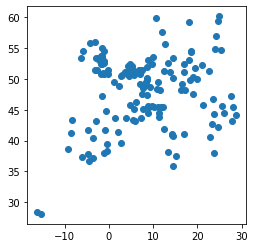

In [44]:
output_df.plot()

In [45]:
output_df.crs

<Geographic 2D CRS: EPSG:4258>
Name: ETRS89
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Moldova; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain; Sweden; Switzerland; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-16.1, 32.88, 40.18, 84.73)
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [48]:
output_df.rename(columns = {'Code_Country': 'CC'}, inplace = True)

In [49]:
fp = os.path.join(INDIR, "city_coordinates.shp")
output_df.to_file(fp)

/Users/brecht/opt/anaconda3/envs/citynet/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Calculate distances
- Planar or Geodesic distance
- Join the pairs dataset

In [4]:
fp = os.path.join(INDIR, "city_coordinates.shp")
gdf = gpd.read_file(fp)

In [5]:
gdf.head()

,id_MUA,Mua,Mua_en,Mua_fr,SizeMUA1k,CC,geometry
0,NL01410,Utrecht,Utrecht,Utrecht,390,NL,POINT (5.11148 52.09863)
1,NL01354,Eindhoven,Eindhoven,Eindhoven,316,NL,POINT (5.47234 51.45709)
2,NL01331,Amsterdam,Amsterdam,Amsterdam,1052,NL,POINT (4.87429 52.37074)
3,NL01403,Rotterdam,Rotterdam,Rotterdam,1025,NL,POINT (4.47374 51.92364)
4,PL01510,Poznan,Poznan,Poznan,679,PL,POINT (16.91751 52.40734)


In [12]:
gdf.geometry[0].distance(gdf.geometry[4])

11.810063106973496

In [13]:
gdf.crs

<Geographic 2D CRS: EPSG:4258>
Name: ETRS89
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Moldova; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain; Sweden; Switzerland; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-16.1, 32.88, 40.18, 84.73)
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Option 1:
Calculate distance on projected coordinates. This *will* result in destortion. (Especially considering how far north we are). Somewhat minimized by using a suitable projection. (I believe this to be, EPSG: 3035 - ETRS89-extended / LAEA Europe). 

In [28]:
gdf = gdf.to_crs('EPSG:3035')

In [29]:
gdf.crs

<Derived Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Europ

In [40]:
gdf.geometry[0].distance(gdf.geometry[1])/ 1000

75.61913916162662

In [37]:
gdf.head()

,id_MUA,Mua,Mua_en,Mua_fr,SizeMUA1k,CC,geometry
0,NL01410,Utrecht,Utrecht,Utrecht,390,NL,POINT (3986294.355 3232207.546)
1,NL01354,Eindhoven,Eindhoven,Eindhoven,316,NL,POINT (4006534.020 3159347.337)
2,NL01331,Amsterdam,Amsterdam,Amsterdam,1052,NL,POINT (3972221.509 3263538.886)
3,NL01403,Rotterdam,Rotterdam,Rotterdam,1025,NL,POINT (3941243.288 3215906.046)
4,PL01510,Poznan,Poznan,Poznan,679,PL,POINT (4790943.558 3277681.393)


### Join the pairs dataset

In [165]:
# load the pairs dataset
file_name = "citypairs_english_20220603.csv"
fp = os.path.join(OUTDIR, file_name)
pairs_df_en = pd.read_csv(fp, sep=';')

In [166]:
pairs_df_en['collocation_en'] = pairs_df_en['collocation']

In [167]:
pairs_df_en

,city_A,city_B,collocation,collocation_en
0,Paris,London,21874.0,21874.0
1,Paris,Madrid,3394.0,3394.0
2,Paris,Berlin,7899.0,7899.0
3,Paris,Milan,3342.0,3342.0
4,Paris,Barcelona,2397.0,2397.0
...,...,...,...,...
11170,Brasov,Valletta,0.0,0.0
11171,Brasov,Ghent,1.0,1.0
11172,Bonn,Valletta,4.0,4.0
11173,Bonn,Ghent,22.0,22.0


In [168]:
gdf['Mua_en'] = [unidecode.unidecode(city) for city in gdf['Mua_en']]

In [169]:
gdf_min = gdf[['Mua_en', 'SizeMUA1k', 'geometry']]

In [170]:
joined_df = pd.merge(pairs_df_en, gdf_min, how='left', left_on = 'city_A', right_on = 'Mua_en')

In [171]:
joined_df.shape

(11175, 7)

In [172]:
joined_df.head()

,city_A,city_B,collocation,collocation_en,Mua_en,SizeMUA1k,geometry
0,Paris,London,21874.0,21874.0,Paris,9591,POINT (3760015.368 2889948.695)
1,Paris,Madrid,3394.0,3394.0,Paris,9591,POINT (3760015.368 2889948.695)
2,Paris,Berlin,7899.0,7899.0,Paris,9591,POINT (3760015.368 2889948.695)
3,Paris,Milan,3342.0,3342.0,Paris,9591,POINT (3760015.368 2889948.695)
4,Paris,Barcelona,2397.0,2397.0,Paris,9591,POINT (3760015.368 2889948.695)


In [173]:
joined_df = pd.merge(joined_df, gdf_min, how='left', left_on = 'city_B', right_on = 'Mua_en', suffixes=('_A', '_B'))

In [174]:
joined_df.head()

,city_A,city_B,collocation,collocation_en,Mua_en_A,SizeMUA1k_A,geometry_A,Mua_en_B,SizeMUA1k_B,geometry_B
0,Paris,London,21874.0,21874.0,Paris,9591,POINT (3760015.368 2889948.695),London,8256,POINT (3623219.566 3204183.954)
1,Paris,Madrid,3394.0,3394.0,Paris,9591,POINT (3760015.368 2889948.695),Madrid,4955,POINT (3161798.324 2030549.871)
2,Paris,Berlin,7899.0,7899.0,Paris,9591,POINT (3760015.368 2889948.695),Berlin,3776,POINT (4552085.153 3273010.955)
3,Paris,Milan,3342.0,3342.0,Paris,9591,POINT (3760015.368 2889948.695),Milan,3698,POINT (4256391.191 2484870.286)
4,Paris,Barcelona,2397.0,2397.0,Paris,9591,POINT (3760015.368 2889948.695),Barcelona,3659,POINT (3664331.118 2067683.425)


In [175]:
joined_df.shape

(11175, 10)

In [176]:
joined_df.geometry_A[0].distance(joined_df.geometry_B[0])/ 1000

342.7198407546638

In [177]:
def city_dist(row):
    dist = row['geometry_A'].distance(row['geometry_B']) / 1000
    return dist

In [178]:
joined_df['distance'] = joined_df.apply(city_dist, axis = 1)

In [179]:
for index, row in joined_df.iterrows():
    try: 
        row['geometry_A'].distance(row['geometry_B']) / 1000
    except:
        print(row)

In [180]:
joined_df

,city_A,city_B,collocation,collocation_en,Mua_en_A,SizeMUA1k_A,geometry_A,Mua_en_B,SizeMUA1k_B,geometry_B,distance
0,Paris,London,21874.0,21874.0,Paris,9591,POINT (3760015.368 2889948.695),London,8256,POINT (3623219.566 3204183.954),342.719841
1,Paris,Madrid,3394.0,3394.0,Paris,9591,POINT (3760015.368 2889948.695),Madrid,4955,POINT (3161798.324 2030549.871),1047.105521
2,Paris,Berlin,7899.0,7899.0,Paris,9591,POINT (3760015.368 2889948.695),Berlin,3776,POINT (4552085.153 3273010.955),879.835916
3,Paris,Milan,3342.0,3342.0,Paris,9591,POINT (3760015.368 2889948.695),Milan,3698,POINT (4256391.191 2484870.286),640.685161
4,Paris,Barcelona,2397.0,2397.0,Paris,9591,POINT (3760015.368 2889948.695),Barcelona,3659,POINT (3664331.118 2067683.425),827.813778
...,...,...,...,...,...,...,...,...,...,...,...
11170,Brasov,Valletta,0.0,0.0,Brasov,307,POINT (5529295.231 2631657.414),Valletta,301,POINT (4732026.336 1438539.627),1434.980050
11171,Brasov,Ghent,1.0,1.0,Brasov,307,POINT (5529295.231 2631657.414),Ghent,300,POINT (3881703.383 3123724.104),1719.502407
11172,Bonn,Valletta,4.0,4.0,Bonn,306,POINT (4116262.831 3073236.167),Valletta,301,POINT (4732026.336 1438539.627),1746.824968
11173,Bonn,Ghent,22.0,22.0,Bonn,306,POINT (4116262.831 3073236.167),Ghent,300,POINT (3881703.383 3123724.104),239.931587


In [181]:
# add the french collocations
file_name = "citypairs_french_20220603.csv"
fp = os.path.join(OUTDIR, file_name)
pairs_df_fr = pd.read_csv(fp, sep=';')

joined_df['collocation_fr'] = pairs_df_fr['collocation'].copy()

In [184]:
gravity_df = joined_df[['city_A', 'city_B', 'SizeMUA1k_A', 'SizeMUA1k_B', 
                        'distance', 'collocation_en', 'collocation_fr',]]

In [188]:
gravity_df

,city_A,city_B,SizeMUA1k_A,SizeMUA1k_B,distance,collocation_en,collocation_fr
0,Paris,London,9591,8256,342.719841,21874.0,10733.0
1,Paris,Madrid,9591,4955,1047.105521,3394.0,2404.0
2,Paris,Berlin,9591,3776,879.835916,7899.0,4723.0
3,Paris,Milan,9591,3698,640.685161,3342.0,2713.0
4,Paris,Barcelona,9591,3659,827.813778,2397.0,1696.0
...,...,...,...,...,...,...,...
11170,Brasov,Valletta,307,301,1434.980050,0.0,0.0
11171,Brasov,Ghent,307,300,1719.502407,1.0,0.0
11172,Bonn,Valletta,306,301,1746.824968,4.0,0.0
11173,Bonn,Ghent,306,300,239.931587,22.0,14.0


In [194]:
np.mean(gravity_df['collocation_en'])
np.std(gravity_df['collocation_en'])

435.5334293456543

In [195]:
def normalize_en(row):
    val = (row['collocation_en']-np.mean(gravity_df['collocation_en']))/np.std(gravity_df['collocation_en'])
    return val

def normalize_fr(row): 
    val = (row['collocation_fr']-np.mean(gravity_df['collocation_fr']))/np.std(gravity_df['collocation_fr'])
    return val

In [196]:
# z-score normalisation of collocations
gravity_df['collocation_en_norm'] = gravity_df.apply(normalize_en, axis=1)
gravity_df['collocation_fr_norm'] = gravity_df.apply(normalize_fr, axis=1)

/var/folders/15/8v892gvj639_bp8s5ftm80400000gn/T/ipykernel_46689/3238373789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gravity_df['collocation_en_norm'] = gravity_df.apply(normalize_en, axis=1)


In [197]:
gravity_df.head()

,city_A,city_B,SizeMUA1k_A,SizeMUA1k_B,distance,collocation_en,collocation_fr,collocation_en_norm,collocation_fr_norm
0,Paris,London,9591,8256,342.719841,21874.0,10733.0,50.010477,36.465726
1,Paris,Madrid,9591,4955,1047.105521,3394.0,2404.0,7.579750,8.032372
2,Paris,Berlin,9591,3776,879.835916,7899.0,4723.0,17.923388,15.948923
3,Paris,Milan,9591,3698,640.685161,3342.0,2713.0,7.460356,9.087230
4,Paris,Barcelona,9591,3659,827.813778,2397.0,1696.0,5.290603,5.615418


In [198]:
file_name = "gravity_df_noDUM.csv"
fp = os.path.join(OUTDIR, file_name)
gravity_df.to_csv(fp, index = False, sep = ";")

In [202]:
np.mean(gravity_df.collocation_en_norm)

-1.0173318811777721e-17

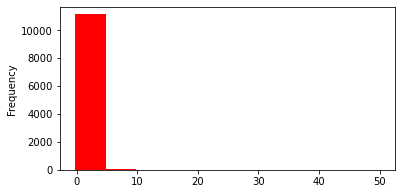

In [208]:
import matplotlib.pyplot as plt
%matplotlib inline

gravity_df['collocation_en_norm'].plot.hist(color = 'red', figsize = (6, 3));

In [214]:
gravity_df[gravity_df.collocation_en == 0]

,city_A,city_B,SizeMUA1k_A,SizeMUA1k_B,distance,collocation_en,collocation_fr,collocation_en_norm,collocation_fr_norm
136,Paris,Busto Arsizio,9591,320,611.016646,0.0,2.0,-0.212993,-0.167521
284,London,Busto Arsizio,8256,320,929.656837,0.0,0.0,-0.212993,-0.174349
414,Madrid,Castellammare di Stabia-Torre Annunziata,4955,362,1541.281532,0.0,0.0,-0.212993,-0.174349
431,Madrid,Busto Arsizio,4955,320,1168.076985,0.0,1.0,-0.212993,-0.170935
560,Berlin,Castellammare di Stabia-Torre Annunziata,3776,362,1312.820353,0.0,1.0,-0.212993,-0.170935
...,...,...,...,...,...,...,...,...,...
11163,Caserta,Valletta,308,301,570.217575,0.0,0.0,-0.212993,-0.174349
11164,Caserta,Ghent,308,300,1377.043354,0.0,1.0,-0.212993,-0.170935
11165,Coventry,Brasov,308,307,2103.180597,0.0,0.0,-0.212993,-0.174349
11170,Brasov,Valletta,307,301,1434.980050,0.0,0.0,-0.212993,-0.174349
